In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [12]:
train_data = pd.read_table('./used_car_train_20200313.csv', sep = ' ',index_col=0)  # index_col将SalesID转换为行索引
train_data.iloc[:,range(0,17)].head()
train_data.head()

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
SaleID,,,,,,,,,,,,,,,,,,,,,
0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [13]:
test_data = pd.read_csv('./used_car_testA_20200313.csv', sep=' ', index_col=0)

In [16]:
# 异常值处理代码
def outliers_proc(data, col_name, scale=3):
    def box_plot_outliers(data_ser, box_scale):
        '''
        箱线图去除异常值
        :param data_ser: 接受pandas.Series格式
        :param box_scale: 箱线图尺度
        :return 
        '''
        iqr = box_scale- (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) -iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)
    
    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print('Description of data less than lower bound is :')
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print('Description of data greater than upper bound is :')
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    sns.boxplot(y=data[col_name], data=data, palette='Set1', ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette='Set2', ax=ax[1])
    return data_n

Delete number is 150000
Now column number is 0
Description of data less than lower bound is :
count    109137.000000
mean         85.448592
std          40.946746
min           0.000000
25%          60.000000
50%          90.000000
75%         116.000000
max         146.000000
Name: power, dtype: float64
Description of data greater than upper bound is :
count    105098.000000
mean        150.766190
std         202.745223
min          79.000000
25%         105.000000
50%         136.000000
75%         170.000000
max       19312.000000
Name: power, dtype: float64


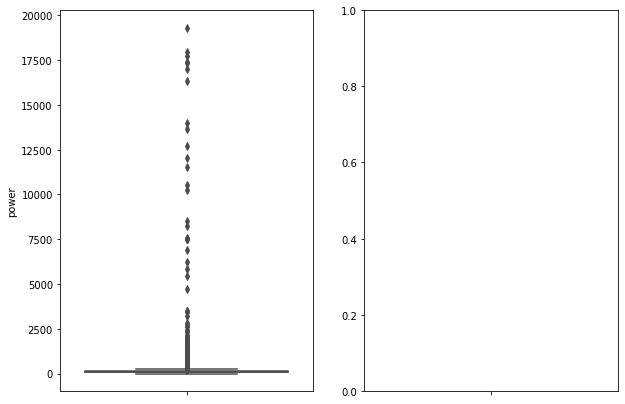

In [17]:
train = outliers_proc(train_data, 'power', scale=3)

In [32]:
train

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14


In [19]:
data = pd.concat([train_data, test_data], ignore_index=True, sort=False)

In [21]:
## 处理时间
# errors 是因为有时间出错的格式
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                        pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [23]:
data['used_time'].isnull().sum()

15101

In [ ]:
## 处理邮编,参考德国邮编?
data['city'] = data['regionCode'].apply(lambda x : str(x)[-3])

In [26]:
# 数据分桶
# LightGBM改进XGB时增加了数据分桶，从而增强模型的泛化性
bin = [i*10 for i in range(31)] # 分为31桶
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [27]:
data.to_csv('bdata_for_tree.csv', index = 0)

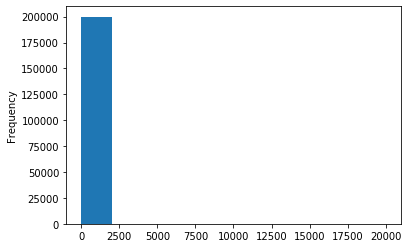

In [28]:
# 为LR NN 构造特征
data['power'].plot.hist()

In [30]:
train['power'].plot.hist()

TypeError: no numeric data to plot